In [1]:
import os
import itk
import nrrd
import time
import pandas as pd
import random
import numpy as np
import skimage as ski
import nibabel as nib
import SimpleITK as sitk
import scipy.ndimage as ndi
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict
from difflib import SequenceMatcher

### images to show
02014629_ko_mca_tof

# Crop image

In [192]:
subject_name1     = '02053152-mca-rechts-new_tof.nii.gz'
path_to_init_img1 = '/scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated/02053152-MCA-rechts-NEW/02053152-mca-rechts-new_tof.nii.gz' 
img_init1         = nib.load(path_to_init_img1)

subject_name2         = '02014629_ko_mca_tof.nii.gz'
path_to_init_img2     = '/scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated/02014629_KO_MCA/02014629_ko_mca_tof.nii.gz' 
img_init2             = nib.load(path_to_init_img2)

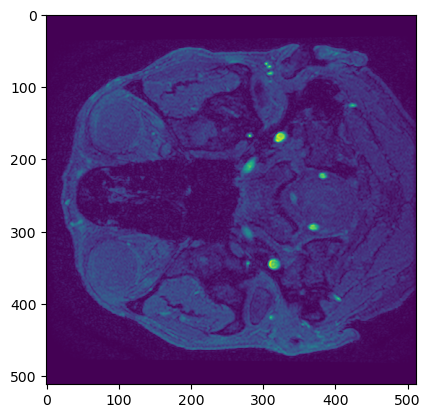

In [200]:
plt.imshow(img_init1.get_fdata()[:,:,10])

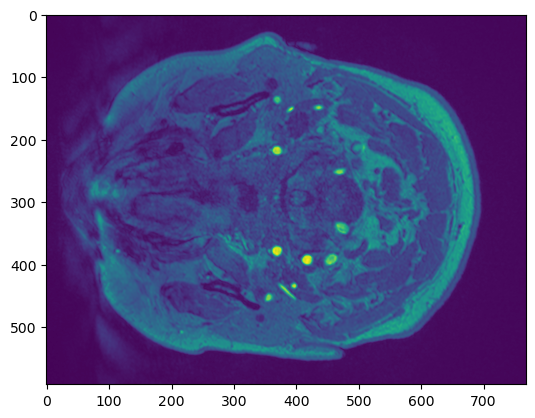

In [212]:
plt.imshow(img_init2.get_fdata()[:,:,10])

In [56]:
subject_name         = '02014629_ko_mca_tof.nii.gz'

path_to_init_img     = '/scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated/02014629_KO_MCA/02014629_ko_mca_tof.nii.gz' 
path_to_cropped_img  = '/scratch/kvergopoulos/SemesterProject/intermediate_results/images_intermediate_folder/cropped_images/02014629_ko_mca_tof.nii.gz'
path_to_seg_crop_img = '/scratch/kvergopoulos/SemesterProject/intermediate_results/images_intermediate_folder/cropped_images/02014629_ko_mca_seg.nii.gz'

In [57]:
img_init1         = nib.load(path_to_init_img)
img_init2         = nib.load(path_to_cropped_img)
img_seg           = nib.load(path_to_seg_crop_img)

In [58]:
print(img_init1.get_fdata().shape)

(592, 768, 150)


In [59]:
print(img_init2 .get_fdata().shape)

(592, 768, 139)


In [28]:
assert np.all(img_init2.get_fdata()[:,:,0] - img_init1.get_fdata()[:,:,11]) == 0

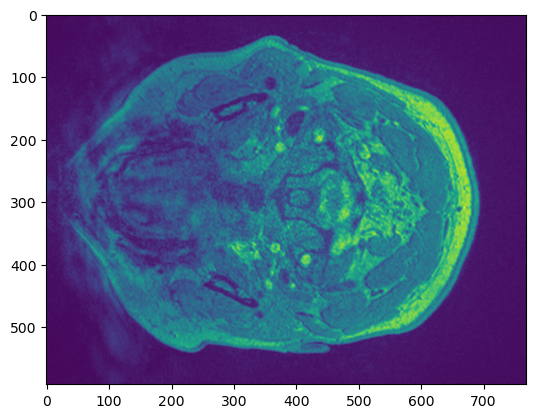

In [78]:
plt.imshow(img_init1.get_fdata()[:,:,11+0])

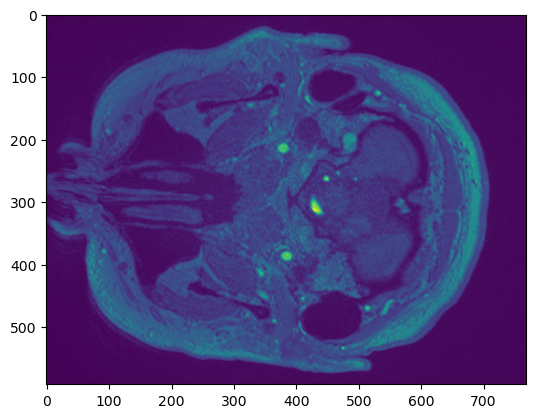

In [64]:
plt.imshow(img_init2.get_fdata()[:,:,20])

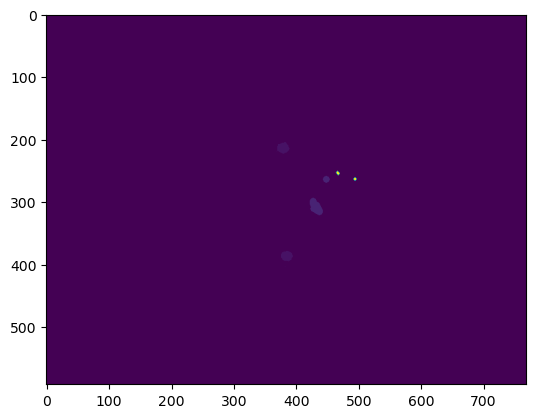

In [63]:
plt.imshow(img_seg.get_fdata()[:,:,20])

# N4 images

In [65]:
path_to_n4_folder_sh4 = '/scratch/kvergopoulos/SemesterProject/intermediate_results/images_intermediate_folder/n4_corrected_sh4' 
path_to_logbias_sh4   = '/scratch/kvergopoulos/SemesterProject/intermediate_results/n4_log_bias_sh4'
subject_name          = '02014629_ko_mca'

init_image        = os.path.join(path_to_n4_folder_sh4, subject_name + '_tof.nii.gz')
img_n4_sh4        = os.path.join(path_to_n4_folder_sh4, subject_name + '_mask.nii.gz')
img_log_bias_sh4  = os.path.join(path_to_logbias_sh4, 'n4_bias_'+subject_name + '_4.npy')

In [66]:
log_bias_field_sh4 = np.load(img_log_bias_sh4)
img_sh4            = nib.load(img_n4_sh4)
img_init           = nib.load(init_image)

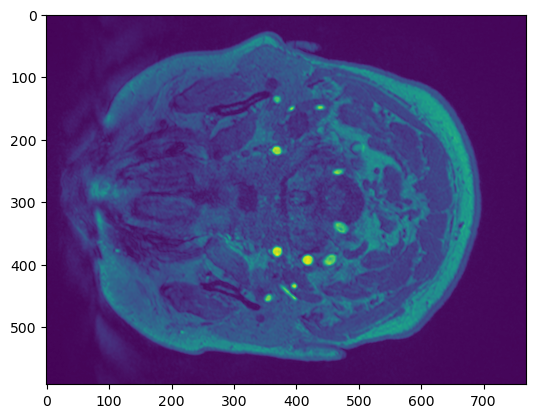

In [67]:
plt.imshow(img_init.get_fdata()[:,:,0])

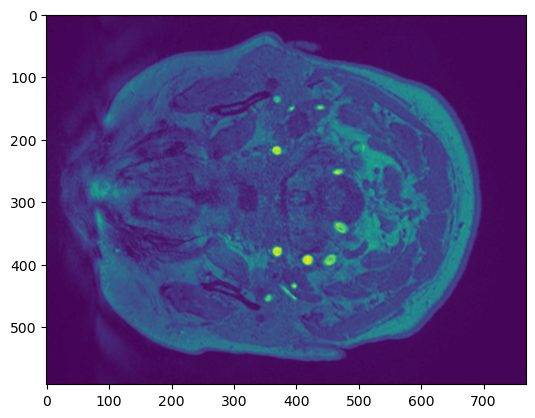

In [71]:
plt.imshow(img_sh4.get_fdata()[:,:,0])

(<matplotlib.image.AxesImage at 0x7fd5a92c36d0>,
 <matplotlib.colorbar.Colorbar at 0x7fd5a90e3d90>)

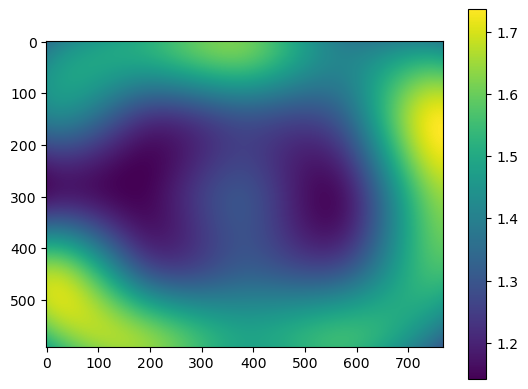

In [77]:
plt.imshow(log_bias_field_sh4[:,:,10]), plt.colorbar()

# Skull Stripping

In [124]:
subject_name = '04270916_vs_acomm_tof.nii.gz'

In [125]:
path_to_n4_sh4      = '/scratch/kvergopoulos/SemesterProject/intermediate_results/images_intermediate_folder/n4_corrected_sh4'
path_to_sk_st       = '/scratch/kvergopoulos/SemesterProject/intermediate_results/images_intermediate_folder/skull_stripped'

In [126]:
img_sh4            = nib.load(os.path.join(path_to_n4_sh4, subject_name))
img_skl            = nib.load(os.path.join(path_to_sk_st, subject_name)) 

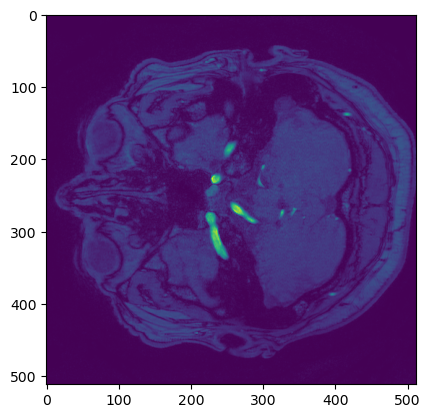

In [135]:
plt.imshow(img_sh4.get_fdata()[:,:,20])

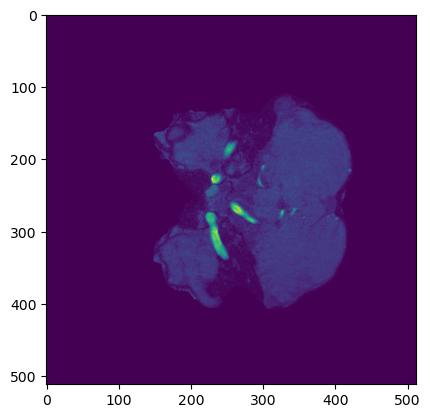

In [136]:
plt.imshow(img_skl.get_fdata()[:,:,20])

# Coarse Masks

In [167]:
subject_name         = '10083905_gluk_mca_tof.nii.gz'
subject_coars_mask   = '10083905_gluk_mca_mask.nii.gz'
subject_name_gt_mask = '10083905_gluk_mca_seg.nii.gz'

In [168]:
path_to_n4_corr_sh4 = '/scratch/kvergopoulos/SemesterProject/intermediate_results/images_intermediate_folder/n4_corrected_sh4'
path_to_coarse_mask = '/scratch/kvergopoulos/SemesterProject/intermediate_results/images_intermediate_folder/global_thresholded_99.5'

In [173]:
img_init  = nib.load(os.path.join(path_to_n4_corr_sh4, subject_name))
img_init2 = nib.load(os.path.join(path_to_coarse_mask, subject_name))
img_final = nib.load(os.path.join(path_to_coarse_mask, subject_coars_mask)) 
img_gt    = nib.load(os.path.join(path_to_coarse_mask, subject_name_gt_mask)) 

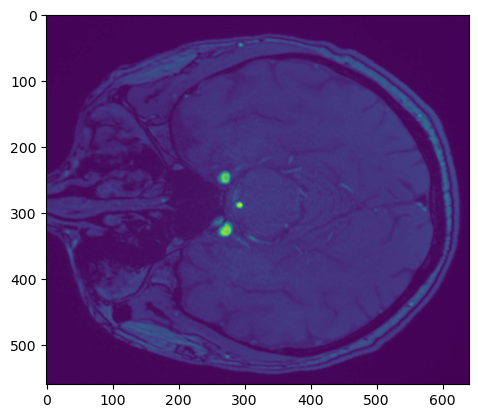

In [221]:
plt.imshow(img_init.get_fdata()[:,:,90])

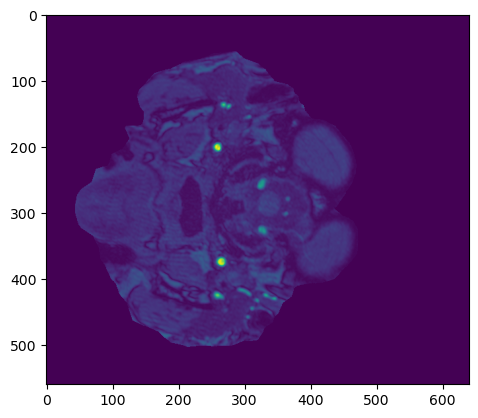

In [181]:
plt.imshow(img_init2.get_fdata()[:,:,15])

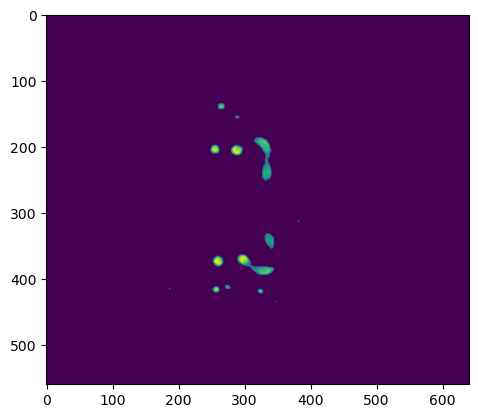

In [178]:
plt.imshow(img_final.get_fdata()[:,:,5])

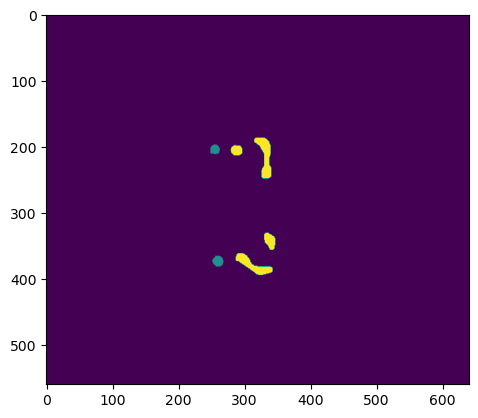

In [179]:
plt.imshow(img_gt.get_fdata()[:,:,5])

# Label Correction

In [2]:
def read_classes_from_nrrd(path):
    data, header = nrrd.read(path)
    segment_keys = {}
    for key in header.keys():
        print(key, header[key])
        if key.startswith('Segment') and key[7].isdigit():
            segid, cont = key.split('_')
            index = int(segid[7:])
            if index not in segment_keys.keys():    segment_keys[index] = {}
            segment_keys[index][cont] = header[key]
    label_list = pd.DataFrame.from_dict(segment_keys, orient='index')
    label_list = label_list[['Name', 'LabelValue']].astype({'LabelValue':int}).sort_values(by=['LabelValue'])
    return label_list.rename(columns={'Name':'name', 'LabelValue':'label id'})

In [3]:
def match_labels(color_table, class_table):
    mapping        = {}
    i              = 0
    js             = list(range(class_table.shape[0]))
    matches_ratio  = []

    while len(js) != 0 and i < color_table.shape[0]:
        matches    = [SequenceMatcher(None, class_table['name'].iloc[j], color_table['name'].iloc[i]).ratio() for j in js]
        j          = js[matches.index(max(matches))]
        mapping[j] = [class_table['label id'].iloc[j], color_table['label id'].iloc[i], class_table['name'].iloc[j], color_table['name'].iloc[i]] 
        i          = i+1
        js.remove(j)
        matches_ratio.append(max(matches))
    
    if np.mean(matches_ratio) < 0.75:
        print('Warning: Mapping did not work correctly', np.mean(matches_ratio))
    
    for j in js:
        mapping[j] = [class_table['label id'].iloc[j], None, class_table['name'].iloc[j], None]
    return mapping

In [4]:
def correct_labels(data, mapping):
    if isinstance(mapping, pd.DataFrame):
        label_mapping = mapping[['file_id', 'class_id']].dropna(axis='index', how='any').set_index('file_id').to_dict()['class_id']
    else:
        label_mapping = mapping 
    return map_labels(data, label_mapping).astype(int)

def map_labels(data, label_mapping):
    l_keys = []
    for key in label_mapping.keys():
        if label_mapping[key] != key:
            l_keys.append(key)

    data_new = np.copy(data)
    x_dim, y_dim, z_dim = data_new.shape
    for x in range(x_dim):
        for y in range(y_dim):
            for z in range(z_dim):
                if int(data_new[x,y,z]) in l_keys:
                    data_new[x,y,z] = int(label_mapping[int(data_new[x,y,z])])
    return data_new

In [5]:
def create_corrected_mask(mri_path, mapping_path, wrong_mask_path):
    
    path_components = wrong_mask_path.split('/')
    name            = path_components[-2].lower()
    print('Reading label mapping from', mapping_path)
    label_mapping = pd.read_csv(mapping_path, dtype={'class_id':int,
                                                     'file_id':float,
                                                     'class_name':str,
                                                     'name_in_file':str})
    print('Reading wrong mask from', wrong_mask_path)
    nii_wrong_mask = nib.load(wrong_mask_path)
    if nib.aff2axcodes(nii_wrong_mask.affine) == ('L', 'P', 'S'): pass
    else: nii_wrong_mask = reorient(nii_wrong_mask, ('L', 'P', 'S'))
    
    data_corr      = correct_labels(nii_wrong_mask.get_fdata(), label_mapping) 
    affine_new     = nii_wrong_mask.affine.copy()

    ## sanity check. Affine matrix from wrong mask and init image match
    # A deviation was observed.
    try: 
        tof_list       = [i for i in os.listdir(mri_path) if i.lower().find('tof')!=-1 \
                        and i.lower().endswith('.nii.gz')]
        assert len(tof_list) == 1
        tof_image = nib.load(os.path.join(mri_path, tof_list[0]))
        np.testing.assert_almost_equal(affine_new, tof_image.affine, 
                                       decimal=6, err_msg = 'deviation < 6th decimal')
    except AssertionError as msg:
        print(msg)
        if np.max(affine_new - tof_image.affine) > 1:
            print("init image", nib.aff2axcodes(tof_image.affine))
            print("segm image", nib.aff2axcodes(nii_wrong_mask.affine))
            print("Warning: The two affine matrices differ a lot mirror the segmentation mask")

    '''
    nii_corr_mask  = nib.Nifti1Image(data_corr.astype(int), 
                                     tof_image.affine.copy(), 
                                     tof_image.header, 
                                     nii_wrong_mask.get_data_dtype())
    
    '''
    nii_corr_mask = nib.Nifti1Image(data_corr.astype(int), 
                                     affine_new.copy(), 
                                     nii_wrong_mask.header, 
                                     nii_wrong_mask.get_data_dtype())
                                     
    head, tail = os.path.split(wrong_mask_path)

    #print('Saving the new mask in', os.path.join(head, name + '_corrected_' + tail))
    #nib.save(nii_corr_mask, os.path.join(head, name + '_corrected_' + tail))

    # save also a mask with values the intensities of the vessels, not the labels
    # maybe it will be usefull for the feature maps
    tof_image_data   = tof_image.get_fdata().copy()
    data_corr_2      = np.where(data_corr > 0, tof_image_data, 0)
    # this seg mask is created based on tof image. So, it's better
    # to use tof's image header.
    nii_corr_mask_2  = nib.Nifti1Image(data_corr_2,
                                       tof_image.affine.copy(),
                                       tof_image.header,
                                       tof_image.get_data_dtype())
    #print('Saving the new mask in', os.path.join(head, name + '_real_corrected_' + tail))
    #nib.save(nii_corr_mask_2, os.path.join(head, name + '_real_corrected_' + tail))

In [6]:
path_to_original = '/scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_Originals'

In [7]:
class_table = pd.read_excel(os.path.join(path_to_original, 'class_labels.xlsx'))

In [8]:
mri_path    = os.path.join(path_to_original, '10804920_ARS_MCA') 
seg_path     = os.path.join(mri_path, 'Segmentation_4.seg.nrrd')
seg_nii      = 'Segmentation_4.nii'

file_classes = read_classes_from_nrrd(seg_path)
print(file_classes)
mapping      = match_labels(file_classes, class_table)
print(mapping)

type unsigned char
dimension 3
space left-posterior-superior
sizes [560 640 200]
space directions [[ 2.96321842e-01 -1.29170560e-02 -1.26996632e-02]
 [ 1.29376907e-02  2.96592885e-01  2.05788132e-04]
 [ 2.56242005e-02 -1.53367740e-03  5.99450614e-01]]
kinds ['domain', 'domain', 'domain']
encoding gzip
space origin [-89.68175565 -69.87721661 -60.70409357]
Segment0_Color 0.501961 0.682353 0.501961
Segment0_ColorAutoGenerated 1
Segment0_Extent 78 492 124 475 2 183
Segment0_ID Segment_1
Segment0_LabelValue 1
Segment0_Layer 0
Segment0_Name CA
Segment0_NameAutoGenerated 0
Segment0_Tags Segmentation.Status:completed|TerminologyEntry:Segmentation category and type - 3D Slicer General Anatomy list~SCT^85756007^Tissue~SCT^85756007^Tissue~^^~Anatomic codes - DICOM master list~^^~^^|
Segment10_Color 0.752941 0.407843 0.345098
Segment10_ColorAutoGenerated 1
Segment10_Extent 78 492 124 475 2 183
Segment10_ID Segment_11
Segment10_LabelValue 11
Segment10_Layer 0
Segment10_Name AComm
Segment10_NameAuto

In [15]:
mri_path_2 = '/scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated/10804920_ARS_MCA'
create_corrected_mask(mri_path_2 , 
                      os.path.join(mri_path_2 , 'label_assignment2.csv'), 
                      os.path.join(mri_path_2 , seg_nii))

Reading label mapping from /scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated/10804920_ARS_MCA/label_assignment2.csv
Reading wrong mask from /scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated/10804920_ARS_MCA/Segmentation_4.nii
Saving the new mask in /scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated/10804920_ARS_MCA/10804920_ars_mca_corrected_Segmentation_4.nii
Saving the new mask in /scratch/kvergopoulos/SemesterProject/datasets/USZ_BrainArtery_updated/10804920_ARS_MCA/10804920_ars_mca_real_corrected_Segmentation_4.nii


# Testing

In [399]:
import skimage
import scipy
from skimage.morphology import binary_closing, binary_opening, ball

In [366]:
subject_name  = '02053152-mca-rechts-new_tof.nii.gz'
path_to_n4_corr_sh1 = '/scratch/kvergopoulos/SemesterProject/datasets/n4_corrected_shrink1'
img_sh1            = nib.load(os.path.join(path_to_n4_corr_sh1, subject_name))

In [421]:
img = img_sh1.get_fdata()
sigma = 1.0
alpha = 0.5
beta = 0.5
gamma = 15.0
black_ridges = False

enchanced_image = skimage.filters.frangi(img, sigmas=range(1, 10, 2), scale_range=None, scale_step=None, 
                                         alpha=alpha, beta=beta, gamma=gamma, black_ridges=True)

In [427]:
selem_size = 3
binary_opening(img, np.ones((selem_size, selem_size, selem_size)))

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal